### Spanish Translation A/B Test
A data scientist at X company noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country. One reason could be translation. The team ran the A/B test where each country would have its one translation written by a local. The result is surprised that the non-localized translation was doing better.

You are asked to:

1. Confirm that the test is actually negative. It appears the old version of the site with just one translation across Spain and LatAm performs better.
2. Explain why that might be happening. Are the localized translations really worse?


In [158]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline

### 1. Data overview

In [4]:
test = pd.read_csv('test_table.csv')
test.head(2)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1


In [5]:
user = pd.read_csv('user_table.csv')
user.head(2)

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua


In [6]:
test.shape

(453321, 9)

In [7]:
user.shape

(452867, 4)

In [8]:
test.isnull().sum()

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271444
browser                  0
conversion               0
test                     0
dtype: int64

In [9]:
user.isnull().sum()

user_id    0
sex        0
age        0
country    0
dtype: int64

In [15]:
df = pd.merge(left=user, right=test, how='left', on='user_id')
df.head(2)

,user_id,sex,age,country,date,source,device,browser_language,ads_channel,browser,conversion,test
0,765821,M,20,Mexico,2015-12-02,Ads,Mobile,ES,Yahoo,Android_App,0,1
1,343561,F,27,Nicaragua,2015-12-04,Ads,Web,ES,Facebook,Safari,0,0


In [91]:
df.shape

(452867, 12)

In [92]:
df.isnull().sum()

user_id                  0
sex                      0
age                      0
country                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271174
browser                  0
conversion               0
test                     0
dtype: int64

In [17]:
df.describe()

,user_id,age,conversion,test
count,452867.000000,452867.000000,452867.000000,452867.000000
mean,499944.805166,27.130740,0.049560,0.476462
std,288676.264784,6.776678,0.217034,0.499446
min,1.000000,18.000000,0.000000,0.000000
25%,249819.000000,22.000000,0.000000,0.000000
50%,500019.000000,26.000000,0.000000,0.000000
75%,749543.000000,31.000000,0.000000,1.000000
max,1000000.000000,70.000000,1.000000,1.000000


## 2. AB testing
#### 2.1 Setup
* Primary Aim: to improve the overall conversion rate by launching localized spanish translation website in LatAm countries.
* Null Hypothesis: not make a significant change and might not be effective in improving the conversion rate.
* Alternative Hypothesis: comparing to non-localized version, localized spanish translation significantly increased conversion rate in test group.

#### 2.2 Design
* Unit of deversion: user-ids
* Invariant metrics: number of user-ids
* Evaluation metrics: LatAm conversion rate between control and test groups
* Distribution: given the experiment size and conditions, all the metrics meet the conditions of binomial distribution. 

#### 2.3 Sanity check
* Based on the 95% of confidence interval, the bound should be (0.4984, 0.5016).
* But the observed values are 46.2% of users in control group and 53.8% of users in test group.
* The invariant metric does not pass the sanity check, this is one of the reason why the experiment failed in the end.

In [55]:
df[df['test'] == 1].groupby('conversion').agg(['count', 'mean'])

user_id                    age               test     
             count           mean   count       mean   count mean
conversion                                                       
0           206407  499498.119802  206407  27.115810  206407    1
1             9367  499168.565389    9367  27.102594    9367    1

In [94]:
df[df['test'] == 0].groupby('conversion').agg(['count', 'mean'])

user_id                    age               test     
             count           mean   count       mean   count mean
conversion                                                       
0           224016  500252.955811  224016  27.144021  224016    0
1            13077  502272.506385   13077  27.159058   13077    0

In [90]:
df[df['country'] != 'Spain'].groupby(['test', 'conversion']).agg(['count', 'mean'])

user_id                    age           
                  count           mean   count       mean
test conversion                                          
0    0           176362  500310.709291  176362  27.141760
     1             8949  501717.826573    8949  27.171304
1    0           206407  499498.119802  206407  27.115810
     1             9367  499168.565389    9367  27.102594

In [113]:
nCont_LatAm = 176362+8949
nCont_LatAm

185311

In [114]:
nTest_LatAm = 206407+9367
nTest_LatAm

215774

In [117]:
nUser_LatAm = nCont_LatAm+nTest_LatAm
nUser_LatAm

401085

In [150]:
pCont_LatAm = round(nCont_LatAm/nUser_LatAm, 4)
pCont_LatAm

0.462

In [149]:
pTest_LatAm = round(nTest_LatAm/nUser_LatAm, 4)
pTest_LatAm 

0.538

In [143]:
d_LatAm = 0.5
se_LatAm = round(np.sqrt(0.5*0.5/nUser_LatAm), 4)
se_LatAm 

0.0008

In [144]:
m_LatAm = round(1.96*se_LatAm, 4)
m_LatAm

0.0016

In [145]:
lower_LatAm = d_LatAm - m_LatAm
lower_LatAm

0.4984

In [146]:
uppper_LatAm = d_LatAm + m_LatAm 
uppper_LatAm 

0.5016

#### 2.4 Effect size test
* Based on 95% of confidence interval, calculated the bound is (-0.0063, -0.0035), which means there is a negative significant difference.  
* Difference of conversion rate in test group and control group is -0.0049, which means test group has lower conversion rate by using localized translation website.   
* Reason: should be the sample size in two groups are not even, control group has much less users than test group.

In [134]:
pCont_Convert = round(8949/nCont_LatAm, 4)
pCont_Convert

0.0483

In [135]:
pTest_Convert = round(9367/nTest_LatAm, 4)
pTest_Convert

0.0434

In [136]:
d = round(pTest_Convert-pCont_Convert, 4)
d 

-0.0049

In [137]:
p = round((8949+9367)/nUser_LatAm, 4)
p

0.0457

In [138]:
se = round(np.sqrt(p*(1-p)*(1/nCont_LatAm+1/nTest_LatAm)), 4)
se 

0.0007

In [139]:
m = round(1.96*se, 4)
m

0.0014

In [132]:
lower = round(d-m, 4)
lower 

-0.0063

In [133]:
upper = round(d+m, 4)
upper

-0.0035

### 3. Data visualization

* From the following plots by country, we can see the conversion rates are roughly the same in two groups, but there are much less users in control group.
* Recommendation: can not say the localized translation is worse or better right now, we have to fix the experiment setup and run more to compare the different results before launching.  

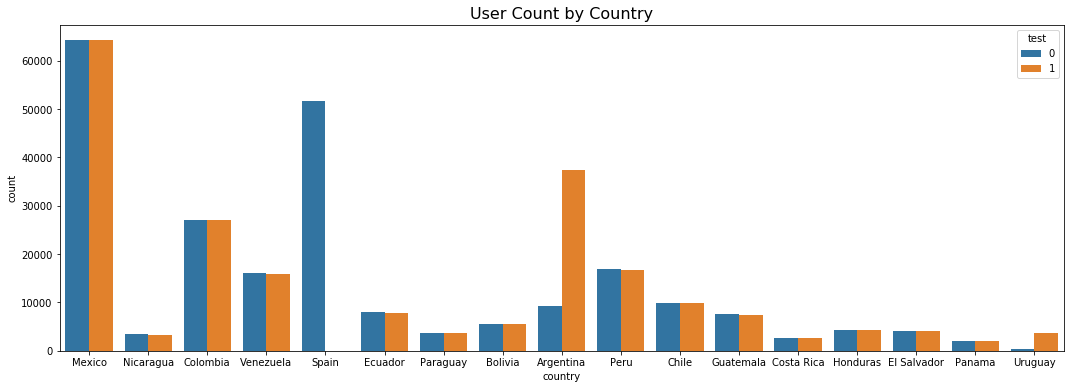

In [157]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.countplot(x='country', hue='test', data=df, ax=ax)
ax.set_title('User Count by Country', fontsize=16)
plt.show()

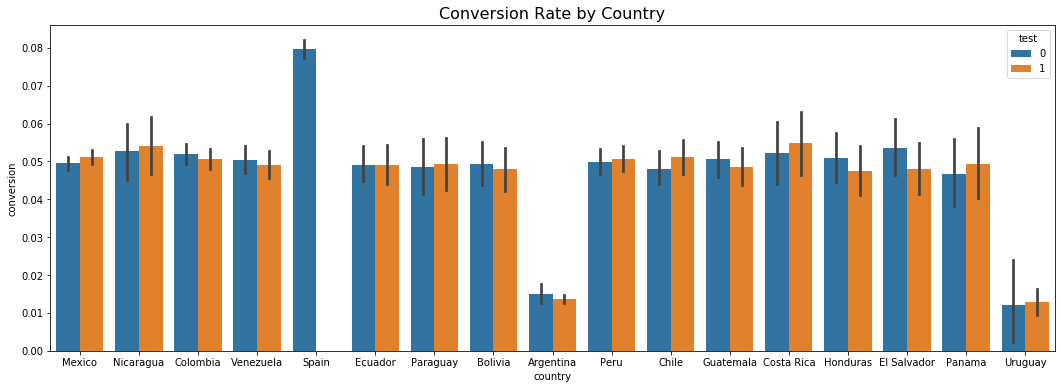

In [156]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='country', y='conversion', hue='test', data=df, ax=ax)
ax.set_title('Conversion Rate by Country', fontsize=16)
plt.show()